<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/Stabiilty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

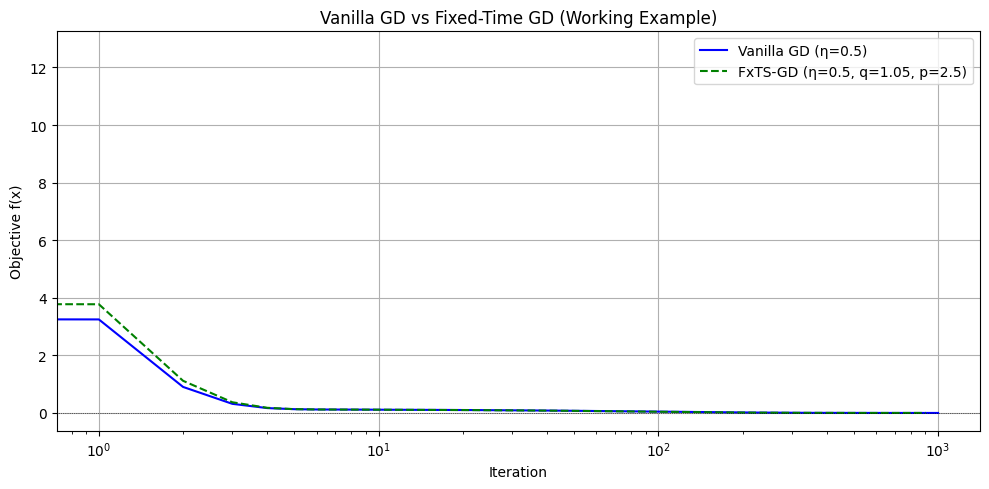

Vanilla GD converged in 1001 steps.
FxTS-GD converged in 905 steps.


In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Objective: Quadratic bowl
def f(x):
    return 0.5 * (x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([x[0], 0.01 * x[1]])

# Parameters
eta_gd = 0.5         # Step size for vanilla GD
eta_fx = 0.5         # Step size for fixed-time GD
p = 2.5
q = 1.05             # Very fast convergence
eps = 1e-6
max_iters = 1000     # Cap

# Initial condition
x0 = np.array([5.0, 5.0])

# Vanilla GD
x_gd = x0.copy()
f_vals_gd = [f(x_gd)]
for _ in range(max_iters):
    if f_vals_gd[-1] <= eps:
        break
    x_gd = x_gd - eta_gd * grad_f(x_gd)
    f_vals_gd.append(f(x_gd))

# FxTS GD
x_fx = x0.copy()
f_vals_fx = [f(x_fx)]
for _ in range(max_iters):
    f_val = f(x_fx)
    if f_val <= eps:
        break
    scale = f_val ** (-(q - 1) / (p - 1))
    x_fx = x_fx - eta_fx * grad_f(x_fx) * scale
    f_vals_fx.append(f(x_fx))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(f_vals_gd, label=f"Vanilla GD (η={eta_gd})", color="blue")
plt.plot(f_vals_fx, label=f"FxTS-GD (η={eta_fx}, q={q}, p={p})", color="green", linestyle="--")
plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.xlabel("Iteration")
plt.ylabel("Objective f(x)")
plt.title("Vanilla GD vs Fixed-Time GD (Working Example)")
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print result
print(f"Vanilla GD converged in {len(f_vals_gd)} steps.")
print(f"FxTS-GD converged in {len(f_vals_fx)} steps.")


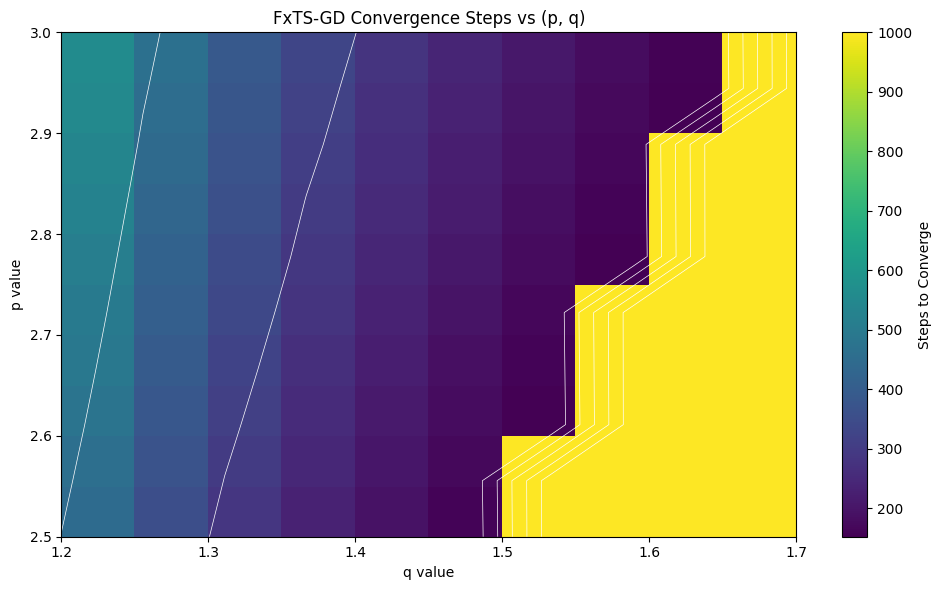

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# --- Objective: Quadratic bowl ---
def f(x):
    return 0.5 * (x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([x[0], 0.01 * x[1]])

# --- Fixed parameters ---
eta_fx = 0.5
eps = 1e-6
max_iters = 1000
x0 = np.array([5.0, 5.0])

# --- Grid of (p, q) values ---
p_values = np.linspace(2.5, 3.0, 10)     # p > 1
q_values = np.linspace(1.2, 1.7, 10)   # q > 1
convergence_steps = np.zeros((len(p_values), len(q_values)))

# --- Grid search ---
for i, p in enumerate(p_values):
    for j, q in enumerate(q_values):
        x = x0.copy()
        steps = 0
        for _ in range(max_iters):
            f_val = f(x)
            if f_val <= eps:
                break
            scale = f_val ** (-(q - 1) / (p - 1))
            x = x - eta_fx * grad_f(x) * scale
            steps += 1
        convergence_steps[i, j] = steps

# --- Plotting heatmap ---
plt.figure(figsize=(10, 6))
plt.imshow(convergence_steps, origin='lower', cmap='viridis',
           extent=[q_values[0], q_values[-1], p_values[0], p_values[-1]],
           aspect='auto')
plt.colorbar(label="Steps to Converge")
plt.xlabel("q value")
plt.ylabel("p value")
plt.title("FxTS-GD Convergence Steps vs (p, q)")
plt.contour(q_values, p_values, convergence_steps, colors='white', linewidths=0.5)
plt.tight_layout()
plt.show()


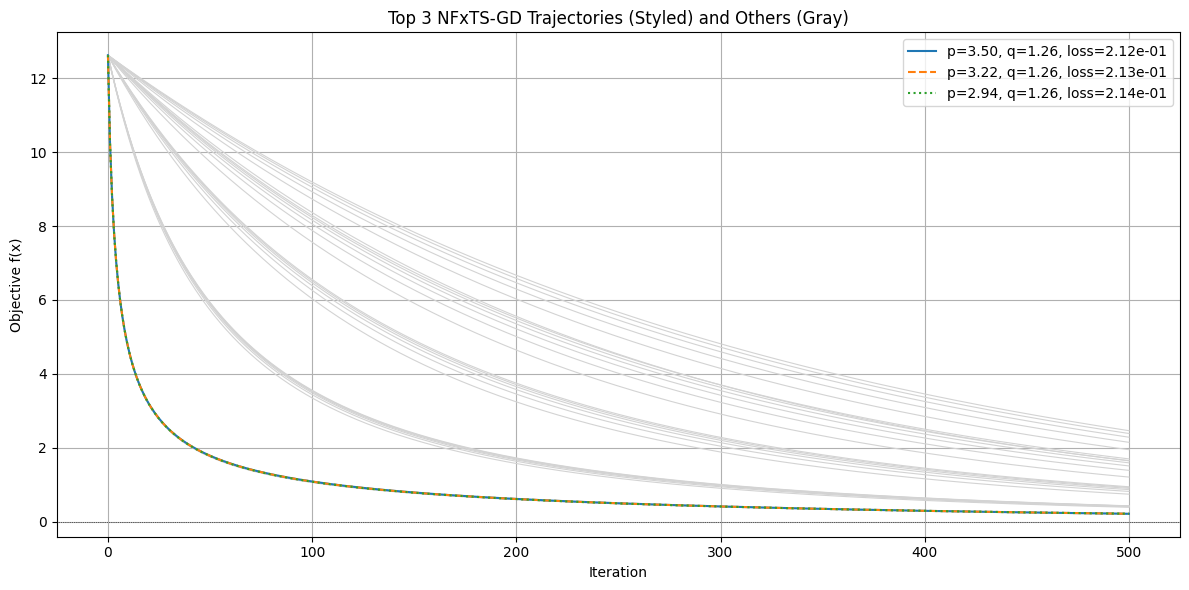

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Objective and derivatives
def f(x):
    return 0.5 * (x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([x[0], 0.02 * x[1]])

def hessian_f(x):
    return np.array([[1.0, 0.0], [0.0, 0.02]])

# Parameters
eta_nfx = 0.001
eps = 1e-6
max_iters = 500
x0 = np.array([5.0, 5.0])
safe_min = 1e-4
grad_max = 1e4  # explosion threshold

# Grid of (p, q) values
p_values = np.linspace(2.1, 3.5, 6)
q_values = np.linspace(1.1, 1.9, 6)

# Store all runs
results = []

for p in p_values:
    for q in q_values:
        x_nfx = x0.copy()
        f_vals_nfx = [f(x_nfx)]
        success = True
        for _ in range(max_iters):
            grad = grad_f(x_nfx)
            grad_norm = np.linalg.norm(grad)
            if f(x_nfx) <= eps or grad_norm < eps or grad_norm > grad_max:
                break
            hess_inv = np.linalg.inv(hessian_f(x_nfx))
            grad_norm = max(grad_norm, safe_min)
            term1 = grad / (grad_norm ** ((p - 2) / (p - 1)))
            term2 = grad / (grad_norm ** ((q - 2) / (q - 1)))
            update = hess_inv @ (term1 + term2)
            x_new = x_nfx - eta_nfx * update
            if f(x_new) > f_vals_nfx[-1]:
                success = False
                break
            x_nfx = x_new
            f_vals_nfx.append(f(x_nfx))
        results.append({
            'p': p,
            'q': q,
            'loss': f_vals_nfx[-1],
            'trajectory': f_vals_nfx,
            'success': success
        })

# Sort by final loss and pick top 3
top_results = sorted(results, key=lambda r: r['loss'])[:3]
line_styles = ['solid', 'dashed', 'dotted']

# Plotting all other runs in light gray
plt.figure(figsize=(12, 6))
for res in results:
    if res not in top_results:
        plt.plot(range(len(res['trajectory'])), res['trajectory'], color='lightgray', linewidth=0.8)

# Top 3 in color with different styles
for idx, res in enumerate(top_results):
    style = line_styles[idx % len(line_styles)]
    label = f"p={res['p']:.2f}, q={res['q']:.2f}, loss={res['loss']:.2e}"
    if not res['success']:
        label += " (stopped)"
    plt.plot(range(len(res['trajectory'])), res['trajectory'], label=label, linestyle=style)

plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.xlabel("Iteration")
plt.ylabel("Objective f(x)")
plt.title("Top 3 NFxTS-GD Trajectories (Styled) and Others (Gray)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
